In [ ]:
!pip list | grep numpy

numpy                              2.0.2


In [ ]:
!pip list | grep pandas

geopandas                          1.0.1
pandas                             2.2.2
pandas-datareader                  0.10.0
pandas-gbq                         0.28.0
pandas-stubs                       2.2.2.240909
sklearn-pandas                     2.2.0


In [ ]:
!pip list | grep matplotlib

matplotlib                         3.10.0
matplotlib-inline                  0.1.7
matplotlib-venn                    1.1.2


In [ ]:
!pip list | grep seaborn

seaborn                            0.13.2


In [ ]:
!pip list | grep sklearn

sklearn-compat                     0.1.3
sklearn-pandas                     2.2.0


In [20]:
# Notebook Setup

# Data, Arrays, Linear Algebra
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add for better Jupyter Notebook compatibility
%matplotlib inline

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
# Source: Obtained from the "Python for Data Science and Machine Learning Bootcamp"
# Reference: https://www.udemy.com/certificate/UC-a9c3a1ee-f780-447f-8bdf-5a9c2afb8dd0/
from google.colab import files
uploaded = files.upload()

Saving titanic_train.csv to titanic_train.csv


In [21]:
# Load Data - continued
filename = list(uploaded.keys())[0]  # Get uploaded filename
df = pd.read_csv(filename)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


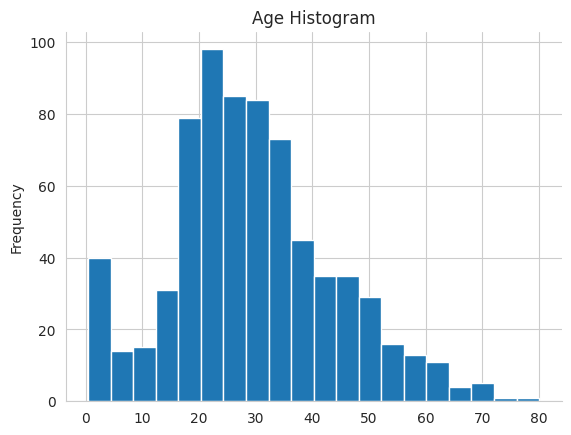

In [29]:
# @title Age

df['Age'].plot(
    kind='hist',
    bins=20,
    title='Age Histogram'
)
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Text(0.5, 1.0, 'Null Values Per Feature')

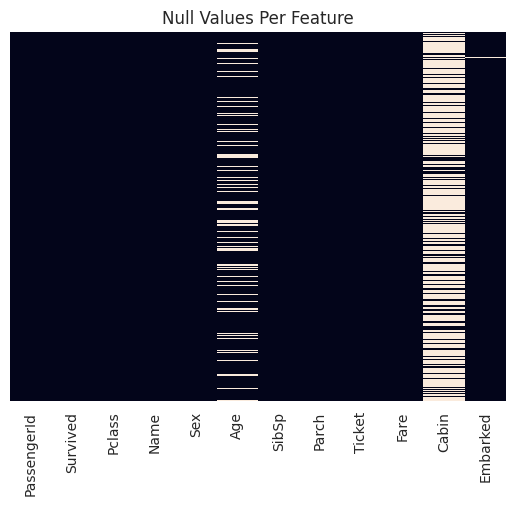

In [16]:
# Investigate Null Values
# Deal with Null Values
sns.heatmap(
    data=df.isnull(),
    yticklabels=False,
    cbar=False
)
plt.title('Null Values Per Feature')

Text(0.5, 1.0, 'Total Survived Per Class')

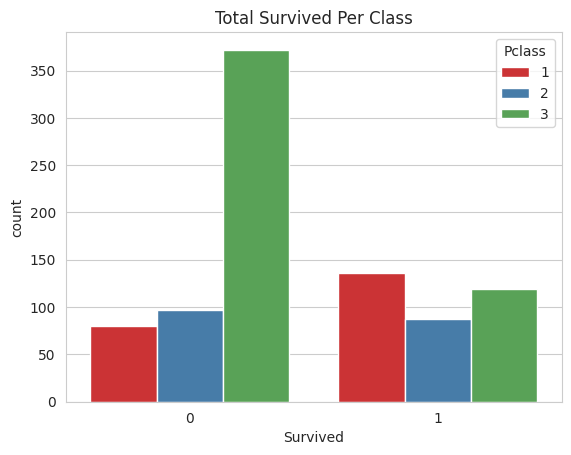

In [17]:
# Investigate Passengers who survived by ticket class
sns.countplot(
    data=df,
    x='Survived',
    hue='Pclass',
    palette='Set1'
)
plt.title('Total Survived Per Class')

Text(0.5, 1.0, 'Passengers with Siblings on Board')

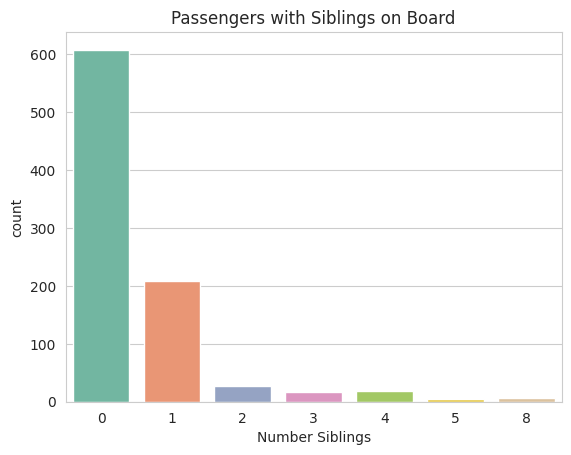

In [27]:
# Investigate Passengers who had a sibling on board
sns.countplot(
    data=df,
    x='SibSp',
    palette='Set2'
  )
plt.xlabel('Number Siblings')
plt.title('Passengers with Siblings on Board')

Text(0.5, 1.0, 'Passengers with Siblings on Board')

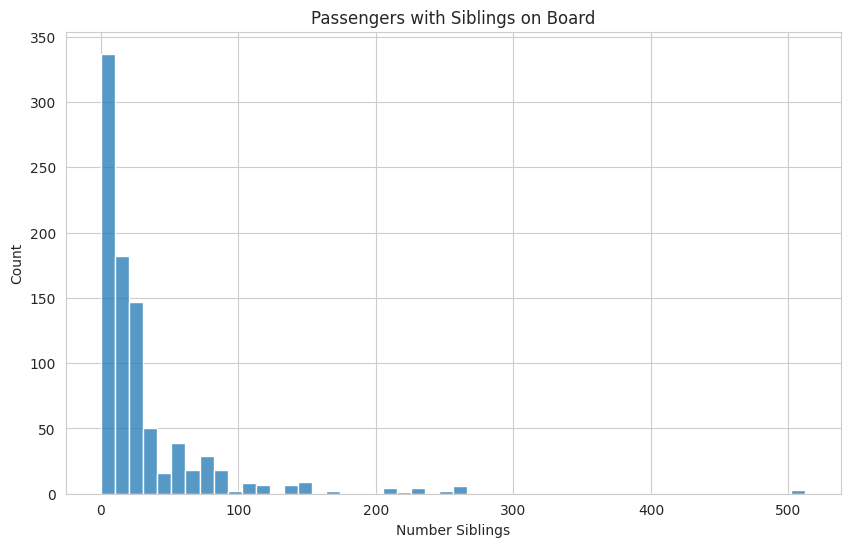

In [35]:
# Investigate Passenger counts per fare price range

plt.figure(figsize=(10, 6)) #figure size (width, height)

sns.histplot(
    data=df,
    x='Fare',
    bins=50,
    palette='Set3'
  )

plt.xlabel('Number Siblings')
plt.title('Passengers with Siblings on Board')

In [34]:
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    discrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate